In [165]:
#task b using ordinary least squares
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import resample
#np.random.seed(2019)

#%matplotlib notebook #interactable 3d plots

#functions from task description
def R2(y_data, y_model): #score function
    return 1 - np.sum((y_data - y_model) ** 2) / np.sum((y_data - np.mean(y_data)) ** 2)
def MSE(y_data,y_model): #mean square error
    n = np.size(y_model)
    return np.sum((y_data-y_model)**2)/n

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

#from lecture notes on Ridge/Lasso regression
def create_X(x, y, n): 
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)

    N = len(x)
    l = int((n+1)*(n+2)/2) # Number of elements in beta
    #print(f'Features/Length beta: {l}') #what amount should we expect?
    X = np.ones((N,l))

    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = (x**(i-k))*(y**k)
    return X

In [166]:
# Making meshgrid of datapoints and compute Franke's function
n = 5 #in task b; up to 5 (this affects the approximate terrain plot)
N = 40
x = np.sort(np.random.uniform(0, 1, N))
y = np.sort(np.random.uniform(0, 1, N))

x_, y_ = np.meshgrid(x,y)

#how does the scaling affect the experiment?
var = 0.1 #variance of noise (?) 
noise = np.random.normal(0, var, len(x_)*len(x_)) 
noise = noise.reshape(len(x_), len(x_))

z = FrankeFunction(x_, y_) + noise #Franke with noise

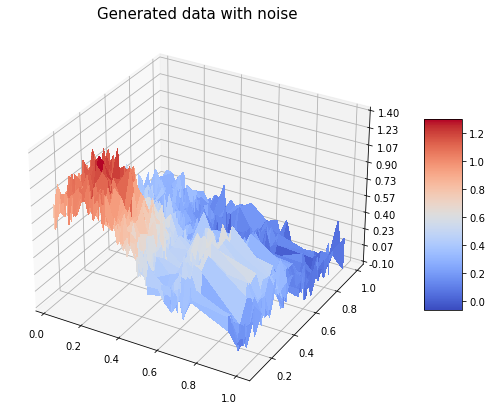

In [167]:
# Plot the surface.
fig = plt.figure(figsize = (13, 7)) 
ax = fig.add_subplot(projection='3d') #

surf = ax.plot_surface(x_, y_, z, cmap = cm.coolwarm,
linewidth = 0, antialiased = False)

ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title('Generated data with noise', fontsize = 15)
plt.show()

In [168]:
X = create_X(x_, y_, n)

# We split the data in test and training data, 20%
X_train, X_test, z_train, z_test = train_test_split(X, np.ravel(z), test_size=0.2)

# matrix inversion to find beta, OLS method
beta = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ z_train
print(beta)

[-2.59859560e-02  1.01547515e+01  7.84780724e+00 -3.99900276e+01
 -2.23293096e+01 -2.76701880e+01  5.14514221e+01  5.90564844e+01
  3.02809598e+01  3.34586050e+01 -2.04856141e+01 -6.63149378e+01
 -1.48672766e+01 -3.82762472e+01 -1.17003147e+01 -9.89802548e-01
  2.15618383e+01  1.59422875e+01 -5.41645426e+00  2.01306848e+01
 -1.66085865e+00]


In [169]:
#scikit 
linreg = LinearRegression()
linreg.fit(X, np.ravel(z))

zmatrix = linreg.predict(X)

# and then make the prediction
ztilde = X_train @ beta
print("Training R2")
print(R2(z_train, ztilde))
print("Training MSE")
print(MSE(z_train, ztilde))

zpredict = X_test @ beta
print("Test R2")
print(R2(z_test, zpredict))
print("Test MSE")
print(MSE(z_test, zpredict))

Training R2
0.8828876828757051
Training MSE
0.011590555533571361
Test R2
0.8868244681244067
Test MSE
0.011704063281361978


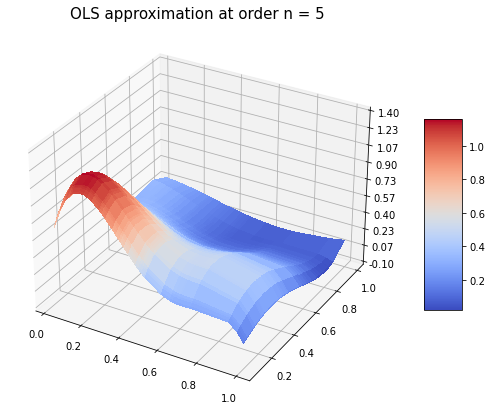

In [170]:
z_matrix = zmatrix.reshape((N, N))

# Plot the surface.
fig = plt.figure(figsize = (13, 7))
ax = fig.add_subplot(projection='3d') #


surf = ax.plot_surface(x_, y_, z_matrix, cmap = cm.coolwarm,
linewidth = 0, antialiased = False)

#predict_surf = ax.plot_trisurf(x, y, zpredict, cmap = cm.coolwarm,
#linewidth = 0, antialiased = False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f'OLS approximation at order n = {n}', fontsize = 15)
plt.show()

In [171]:
#MSE and R2 as function of polynomial degree n
#something is wrong in this block (see plots); R2 should decicively increase with increased n (and be between 0 and 1).

n = 13
MSE_train = np.zeros(n)
R2_train = np.zeros(n)
MSE_test = np.zeros(n)
R2_test = np.zeros(n)
var_B_train = np.zeros(n)
var_B_test = np.zeros(n)
N_ = np.array([b+1 for b in range(n)])
for i in range(0, n): #variables marked to avoid confusion with older
    X_ = create_X(x_, y_, i+1)
    #same divide every iteration
    X_train_, X_test_, z_train_, z_test_ = train_test_split(X_, np.ravel(z), test_size=0.2, random_state = 40)
    beta_ = np.linalg.pinv(X_train_.T @ X_train_) @ X_train_.T @ z_train_
    linreg_ = LinearRegression()
    linreg_.fit(X_, np.ravel(z))
    ztilde_ = X_train_ @ beta_
    zpredict_ = X_test_ @ beta_
    MSE_train[i] = (MSE(z_train_, ztilde_))
    R2_train[i] = (R2(z_train_, ztilde_))
    MSE_test[i] = (MSE(z_test_, zpredict_))
    R2_test[i] = (R2(z_test_, zpredict_))
    #something's wrong here, (X^T X)^-1 does not become a scalar
    #var_B_train[i] = var*np.linalg.pinv(X_train_.T @ X_train_) #from task a
    #var_B_test[i] = var*np.linalg.pinv(X_test_.T @ X_test_)
    var_B_train[i] = np.var(beta_) #is this sufficient?

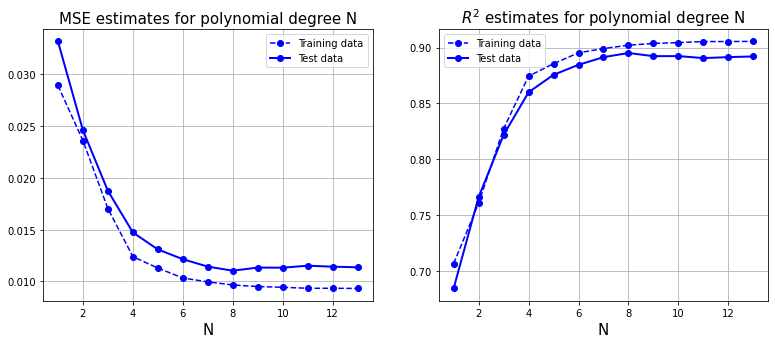

In [172]:
#plotting MSE and R2 as function of polynomial degree
fig = plt.figure(figsize = (13, 5)) 
plt.subplot(1, 2, 1)
plt.title('MSE estimates for polynomial degree N', fontsize = 15)
plt.plot(N_, MSE_train, 'b--', marker = 'o', label = 'Training data')
plt.plot(N_, MSE_test, 'b', marker = 'o', label = 'Test data', linewidth = 2)
plt.xlabel('N', fontsize = 15)
plt.grid(1); plt.legend()


plt.subplot(1, 2, 2)
plt.title('$R^2$ estimates for polynomial degree N', fontsize = 15)
plt.plot(N_, R2_train, 'b--', marker = 'o', label = 'Training data')
plt.plot(N_, R2_test, 'b', marker = 'o', label = 'Test data', linewidth = 2)
plt.xlabel('N', fontsize = 15)
plt.grid(1); plt.legend(); plt.show()

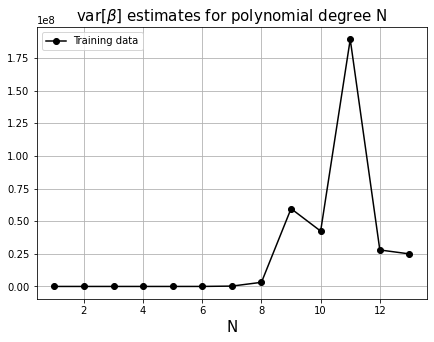

Variance of betas for n = 1 to 5: [0.7061, 0.9452, 7.375, 179.8, 801.6, 12200.0, 263300.0, 3165000.0, 59590000.0, 42390000.0, 189200000.0, 27950000.0, 24920000.0]


In [173]:
#plotting var(beta) as function of polynomial degree

fig = plt.figure(figsize = (7, 5))
plt.title('var[$\\beta$] estimates for polynomial degree N', fontsize = 15)
plt.plot(N_, var_B_train, 'k', marker = 'o', label = 'Training data')
#plt.plot(N_, var_B_test, 'b', marker = 'o', label = 'Test data', linewidth = 2)
plt.xlabel('N', fontsize = 15)
plt.grid(1); plt.legend(); plt.show()

varb = [eval(f'{v:.4}') for v in var_B_train]
print(f'Variance of betas for n = 1 to 5: {varb}')

Are these values reasonable? Considering that the amount of beta-values/features increase with polynomial degree (more parameters to adjust/more degrees of freedom) it is expected that the variance increases, but what do these values tell us? (confidence intervals...)

In [174]:
#####################################################################################################
## task c, lect notes expanded to 3d
## bootleg assisted regression using scikit.learn functions

n_boostraps = 100
maxdegree = n

error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)

#z_train, z_test = train_test_split(z.ravel(), test_size=0.2) #split data to compare resample results with
model = LinearRegression() #instance of linreg class

for degree in range(maxdegree):
    X_ = create_X(x_, y_, degree+1)
    X_train_, X_test_, z_train_, z_test_ = train_test_split(X_, z.ravel(), test_size=0.2, random_state = 40)
    z_pred = np.empty((z_test_.shape[0], n_boostraps))
    for i in range(n_boostraps): #how to do this in 3d?
        X_, z_ = resample(X_train_, z_train_)
        z_pred[:, i] = model.fit(X_, z_).predict(X_test_).ravel() 

    polydegree[degree] = degree

    error[degree] = np.mean( np.mean((z_test_.reshape(-1, 1) - z_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (z_test_.reshape(-1, 1) - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(z_pred, axis=1, keepdims=True) )

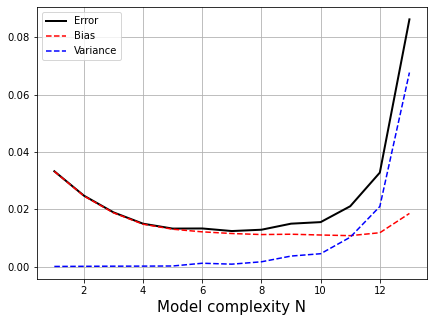

In [175]:
#error, bias, variance plotted as function of complexity
fig = plt.figure(figsize = (7, 5)) 
plt.plot(N_, error, 'k', label='Error', linewidth = 2)
plt.plot(N_, bias, 'r--', label='Bias', linewidth = 1.5)
plt.plot(N_, variance, 'b--', label='Variance', linewidth = 1.5)
plt.xlabel('Model complexity N', fontsize = 15)
plt.legend(); plt.grid(1); plt.show()

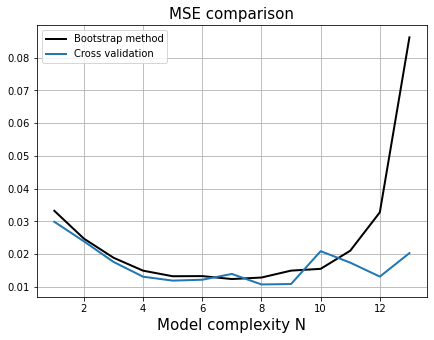

In [177]:
#####################################################################################################
### task d, cross - validation
### script from lecture notes, modified

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

## Cross-validation on OLS regression using KFold only

# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k, shuffle = True)

# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((maxdegree, k))
model = LinearRegression()

N_ = np.array([b+1 for b in range(maxdegree)])
for i in range(maxdegree):
    X_ = create_X(x_, y_, i+1)
    j = 0
    for train_inds, test_inds in kfold.split(X_):
        Xtrain = X_[train_inds]
        ztrain = z.ravel()[train_inds]

        Xtest = X_[test_inds]
        ztest = z.ravel()[test_inds]

        zpred = model.fit(Xtrain, ztrain).predict(Xtest).ravel()
        scores_KFold[i, j] = np.mean((zpred.flatten() - ztest.flatten())**2)
        
        j += 1

estimated_mse_KFold = np.mean(scores_KFold, axis = 1)

fig = plt.figure(figsize = (7, 5)) 
plt.title('MSE comparison', fontsize = 15)
plt.plot(N_, error, 'k', label='Bootstrap method', linewidth = 2)
plt.plot(N_, estimated_mse_KFold, label = 'Cross validation', linewidth = 2)
plt.xlabel('Model complexity N', fontsize = 15)
plt.grid(1); plt.legend(); plt.show()